

## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Установка зависимостей

In [1]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
!nvidia-smi
import torch
torch.cuda.is_available()

Tue Apr 20 14:15:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.89       Driver Version: 460.89       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 166... WDDM  | 00000000:02:00.0  On |                  N/A |
|  0%   49C    P8    21W / 125W |    550MiB /  6144MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

|    0   N/A  N/A      8152    C+G   C:\Windows\explorer.exe         N/A      |
|    0   N/A  N/A      9892    C+G   ...artMenuExperienceHost.exe    N/A      |
|    0   N/A  N/A      9992    C+G   ...es.TextInput.InputApp.exe    N/A      |
|    0   N/A  N/A     10236    C+G   ...in7x64\steamwebhelper.exe    N/A      |
|    0   N/A  N/A     11180    C+G   ...ekyb3d8bbwe\YourPhone.exe    N/A      |
|    0   N/A  N/A     11300    C+G   ...perience\NVIDIA Share.exe    N/A      |
|    0   N/A  N/A     12972    C+G   ...ON Tools Lite\DTAgent.exe    N/A      |
|    0   N/A  N/A     13468    C+G   ...me\Application\chrome.exe    N/A      |
|    0   N/A  N/A     13632    C+G   ...pp\AutodeskDesktopApp.exe    N/A      |
|    0   N/A  N/A     15224    C+G   ...bBrowser\AcWebBrowser.exe    N/A      |
|    0   N/A  N/A     15864    C+G   ...w5n1h2txyewy\SearchUI.exe    N/A      |
+-----------------------------------------------------------------------------+


В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [3]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warningsju
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


c:\users\arcry\anaconda3\envs\myenv\lib\site-packages\skimage\io\manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [4]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [5]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode == 'train': 
            transform = transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.RandomRotation(degrees=30),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(hue=.1, saturation=.1),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        else:
            transform = transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [6]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [7]:
TRAIN_DIR = Path('C:/Users/Arcry/kaggle/journey-springfield/train/simpsons_dataset/')
TEST_DIR = Path('C:/Users/Arcry/kaggle/journey-springfield/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [8]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files, train_dataset, val_dataset = train_test_split(train_val_files, train_val_labels,\
                                          test_size=0.25, \
                                          stratify=train_val_labels)

In [9]:
def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

# Создадим словарь в котором ключами будут персонажи Симпсонов, а значениями списки с путями к картинкам.
dct_path_train = create_dct_path_labels(train_files, train_dataset)

# Дополним картинки классов у которых менее 100 картинок, до 100 картинок в классе
for person in dct_path_train:
    if len(dct_path_train[person]) < 200:
        dct_path_train[person] = dct_path_train[person] * (200 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:200 - len(dct_path_train[person])])
# Проверим что получилось 
for person in dct_path_train:
    print(f"{person}\t{len(dct_path_train[person])}")
new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

val_dataset = SimpsonsDataset(val_files, mode='val')
new_train_dataset = SimpsonsDataset(new_train_files, mode='train')

abraham_grampa_simpson	685
agnes_skinner	200
apu_nahasapeemapetilon	467
barney_gumble	200
bart_simpson	1006
carl_carlson	200
charles_montgomery_burns	895
chief_wiggum	739
cletus_spuckler	200
comic_book_guy	352
disco_stu	200
edna_krabappel	343
fat_tony	200
gil	200
groundskeeper_willie	200
homer_simpson	1684
kent_brockman	373
krusty_the_clown	904
lenny_leonard	233
lionel_hutz	200
lisa_simpson	1015
maggie_simpson	200
marge_simpson	968
martin_prince	200
mayor_quimby	200
milhouse_van_houten	809
miss_hoover	200
moe_szyslak	1089
ned_flanders	1090
nelson_muntz	269
otto_mann	200
patty_bouvier	200
principal_skinner	895
professor_john_frink	200
rainier_wolfcastle	200
ralph_wiggum	200
selma_bouvier	200
sideshow_bob	658
sideshow_mel	200
snake_jailbird	200
troy_mcclure	200
waylon_smithers	200


In [10]:
# val_dataset = SimpsonsDataset(val_files, mode='val')

In [11]:
# # uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions): 
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

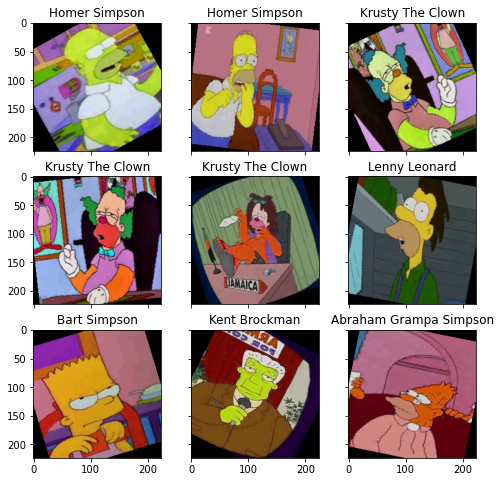

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,10000))
    im_val, label = new_train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [ ]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [10]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [11]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [12]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        scheduler = torch.optim.lr_scheduler.StepLR(opt, 3, 0.5)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            scheduler.step()
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [13]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [14]:
def plt_loss(hist):
    loss, acc, val_loss, val_acc = zip(*hist)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()   

In [15]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(new_train_files, mode='train')

In [16]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

NameError: name 'SimpleCnn' is not defined

Использум молель VGG16

In [24]:
from torchvision import models

In [25]:
model_vgg16 =  models.vgg16(pretrained=True)

In [26]:
model_vgg16.children

<bound method Module.children of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2

In [37]:
torch.cuda.empty_cache()
for i, param in enumerate(model_vgg16.parameters()):
    if i < 8:
        param.requires_grad = False
    else: 
        param.requires_grad = True
    print(param.requires_grad)
    
num_features = 25088
n_classes = len(np.unique(train_val_labels))

model_vgg16.classifier = nn.Linear(num_features, n_classes)

model_vgg16.to(DEVICE)

False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [36]:
history_VGG = train(new_train_dataset, val_dataset, model=model_vgg16, epochs=40, batch_size=64)

epoch:   0%|                                                                                    | 0/40 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 784.00 MiB (GPU 0; 6.00 GiB total capacity; 4.15 GiB already allocated; 29.91 MiB free; 4.21 GiB reserved in total by PyTorch)

In [85]:
loss, acc, val_loss, val_acc = zip(*history_VGG)

NameError: name 'history_VGG' is not defined

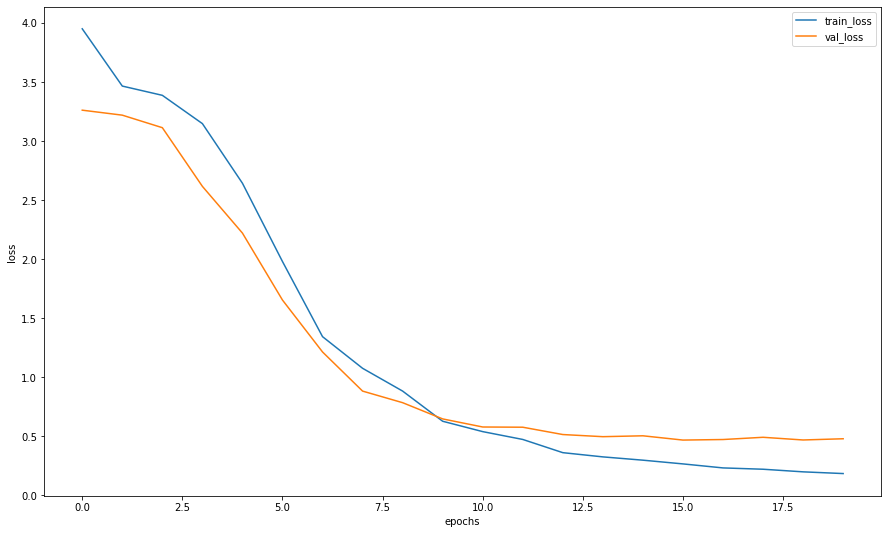

In [84]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
import copy

# сохранить веса нашей нейросети model
model_VGG_men_12 = copy.deepcopy(model_vgg16.state_dict())
torch.save(model_VGG_men_12.state_dict(), "C:/Users/Arcry/kaggle/journey-springfield/model_VGG_men_12.pth")

In [21]:
model_vgg16 =  models.vgg16()

In [23]:
model_vgg16.load_state_dict(torch.load("C:/Users/Arcry/kaggle/journey-springfield/model_VGG_men_12.pth"))

RuntimeError: Error(s) in loading state_dict for VGG:
	Missing key(s) in state_dict: "classifier.0.weight", "classifier.0.bias", "classifier.3.weight", "classifier.3.bias", "classifier.6.weight", "classifier.6.bias". 
	Unexpected key(s) in state_dict: "classifier.weight", "classifier.bias". 

Со всеми весами

In [27]:
torch.cuda.empty_cache()
for i, param in enumerate(model_vgg16.parameters()):
    param.requires_grad = True
    print(param.requires_grad)
    
num_features = 25088
n_classes = len(np.unique(train_val_labels))

model_vgg16.classifier = nn.Linear(num_features, n_classes)

model_vgg16.to(DEVICE)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [28]:
history_VGG = train(new_train_dataset, val_dataset, model=model_vgg16, epochs=15, batch_size=64)

epoch:   0%|                                                                                    | 0/40 [00:05<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 98.00 MiB (GPU 0; 6.00 GiB total capacity; 4.19 GiB already allocated; 25.91 MiB free; 4.21 GiB reserved in total by PyTorch)

In [ ]:
loss, acc, val_loss, val_acc = zip(*history_VGG)

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
import copy

# сохранить веса нашей нейросети model
model_VGG_16_full = copy.deepcopy(model_vgg16.state_dict())
torch.save(model_VGG_16_full, "C:/Users/Arcry/kaggle/journey-springfield/model_VGG_16_full.pth")

RESNET

In [19]:

torch.cuda.empty_cache()

model_resnet = models.resnet18(pretrained=True)

for i, child in enumerate(model_resnet.children()):
    if i not in [9]:
        for param in child.parameters():
            param.requires_grad = False

model_resnet.fc = nn.Sequential(nn.Linear(512,42))

model_resnet = model_resnet.cuda()

In [20]:
model_resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Запустим обучение сети.

In [21]:
history = train(new_train_dataset, val_dataset, model=model_resnet, epochs=40, batch_size=64)

epoch:   0%|                                                                                    | 0/40 [00:00<?, ?it/s]

loss 2.674026788099764


epoch:   2%|█▊                                                                       | 1/40 [03:49<2:29:01, 229.27s/it]


Epoch 001 train_loss: 2.6740     val_loss 1.9628 train_acc 0.3245 val_acc 0.5235
loss 1.8574693983826382


epoch:   5%|███▋                                                                     | 2/40 [07:10<2:14:41, 212.67s/it]


Epoch 002 train_loss: 1.8575     val_loss 1.6866 train_acc 0.5236 val_acc 0.5621
loss 1.5951661063250573


epoch:   8%|█████▍                                                                   | 3/40 [10:34<2:08:38, 208.61s/it]


Epoch 003 train_loss: 1.5952     val_loss 1.5229 train_acc 0.5817 val_acc 0.6064
loss 1.4582900526989329


epoch:  10%|███████▎                                                                 | 4/40 [13:57<2:04:01, 206.71s/it]


Epoch 004 train_loss: 1.4583     val_loss 1.4239 train_acc 0.6183 val_acc 0.6259
loss 1.4005240019736231


epoch:  12%|█████████▏                                                               | 5/40 [17:20<1:59:43, 205.26s/it]


Epoch 005 train_loss: 1.4005     val_loss 1.4043 train_acc 0.6273 val_acc 0.6271
loss 1.3564912612000464


epoch:  15%|██████████▉                                                              | 6/40 [20:36<1:54:35, 202.21s/it]


Epoch 006 train_loss: 1.3565     val_loss 1.3930 train_acc 0.6384 val_acc 0.6421
loss 1.3121235649503475


epoch:  18%|████████████▊                                                            | 7/40 [23:52<1:50:06, 200.19s/it]


Epoch 007 train_loss: 1.3121     val_loss 1.3619 train_acc 0.6505 val_acc 0.6442
loss 1.3032149945735256


epoch:  20%|██████████████▌                                                          | 8/40 [27:08<1:45:56, 198.64s/it]


Epoch 008 train_loss: 1.3032     val_loss 1.3686 train_acc 0.6510 val_acc 0.6446
loss 1.2901148995201182


epoch:  22%|████████████████▍                                                        | 9/40 [30:23<1:42:07, 197.66s/it]


Epoch 009 train_loss: 1.2901     val_loss 1.3376 train_acc 0.6550 val_acc 0.6494
loss 1.264406756208767


epoch:  25%|██████████████████                                                      | 10/40 [33:39<1:38:32, 197.07s/it]


Epoch 010 train_loss: 1.2644     val_loss 1.3336 train_acc 0.6624 val_acc 0.6555
loss 1.2716588496761876


epoch:  28%|███████████████████▊                                                    | 11/40 [36:55<1:35:01, 196.62s/it]


Epoch 011 train_loss: 1.2717     val_loss 1.3105 train_acc 0.6586 val_acc 0.6576
loss 1.2436118302785764


epoch:  30%|█████████████████████▌                                                  | 12/40 [40:10<1:31:34, 196.23s/it]


Epoch 012 train_loss: 1.2436     val_loss 1.3204 train_acc 0.6703 val_acc 0.6496
loss 1.2477236987847733


epoch:  32%|███████████████████████▍                                                | 13/40 [43:25<1:28:10, 195.94s/it]


Epoch 013 train_loss: 1.2477     val_loss 1.3201 train_acc 0.6642 val_acc 0.6532
loss 1.245414735061687


epoch:  35%|█████████████████████████▏                                              | 14/40 [46:41<1:24:51, 195.81s/it]


Epoch 014 train_loss: 1.2454     val_loss 1.3165 train_acc 0.6672 val_acc 0.6548
loss 1.2380344743959633


epoch:  38%|███████████████████████████                                             | 15/40 [49:58<1:21:45, 196.20s/it]


Epoch 015 train_loss: 1.2380     val_loss 1.3120 train_acc 0.6676 val_acc 0.6561
loss 1.2365398427981857


epoch:  40%|████████████████████████████▊                                           | 16/40 [53:14<1:18:26, 196.10s/it]


Epoch 016 train_loss: 1.2365     val_loss 1.3096 train_acc 0.6686 val_acc 0.6571
loss 1.239502916283436


epoch:  42%|██████████████████████████████▌                                         | 17/40 [56:29<1:15:05, 195.91s/it]


Epoch 017 train_loss: 1.2395     val_loss 1.3092 train_acc 0.6703 val_acc 0.6559
loss 1.2354734842665005


epoch:  45%|████████████████████████████████▍                                       | 18/40 [59:45<1:11:46, 195.76s/it]


Epoch 018 train_loss: 1.2355     val_loss 1.3067 train_acc 0.6680 val_acc 0.6578
loss 1.226684350937158


epoch:  48%|█████████████████████████████████▎                                    | 19/40 [1:03:00<1:08:31, 195.77s/it]


Epoch 019 train_loss: 1.2267     val_loss 1.3062 train_acc 0.6729 val_acc 0.6578
loss 1.2275448396944133


epoch:  50%|███████████████████████████████████                                   | 20/40 [1:06:17<1:05:19, 195.99s/it]


Epoch 020 train_loss: 1.2275     val_loss 1.3081 train_acc 0.6725 val_acc 0.6582
loss 1.2379258696458193


epoch:  52%|████████████████████████████████████▊                                 | 21/40 [1:09:33<1:02:02, 195.91s/it]


Epoch 021 train_loss: 1.2379     val_loss 1.3066 train_acc 0.6680 val_acc 0.6572
loss 1.2287342757614725


epoch:  55%|███████████████████████████████████████▌                                | 22/40 [1:12:48<58:43, 195.78s/it]


Epoch 022 train_loss: 1.2287     val_loss 1.3060 train_acc 0.6677 val_acc 0.6574
loss 1.2294332084633763


epoch:  57%|█████████████████████████████████████████▍                              | 23/40 [1:16:04<55:28, 195.78s/it]


Epoch 023 train_loss: 1.2294     val_loss 1.3071 train_acc 0.6657 val_acc 0.6567
loss 1.2259925125629456


epoch:  60%|███████████████████████████████████████████▏                            | 24/40 [1:19:20<52:12, 195.75s/it]


Epoch 024 train_loss: 1.2260     val_loss 1.3053 train_acc 0.6713 val_acc 0.6578
loss 1.2271400078220214


epoch:  62%|█████████████████████████████████████████████                           | 25/40 [1:22:35<48:54, 195.61s/it]


Epoch 025 train_loss: 1.2271     val_loss 1.3051 train_acc 0.6710 val_acc 0.6584
loss 1.2372751650700744


epoch:  65%|██████████████████████████████████████████████▊                         | 26/40 [1:25:50<45:37, 195.55s/it]


Epoch 026 train_loss: 1.2373     val_loss 1.3055 train_acc 0.6704 val_acc 0.6574
loss 1.2324957139489285


epoch:  68%|████████████████████████████████████████████████▌                       | 27/40 [1:29:06<42:21, 195.49s/it]


Epoch 027 train_loss: 1.2325     val_loss 1.3055 train_acc 0.6685 val_acc 0.6571
loss 1.2175626640216952


epoch:  70%|██████████████████████████████████████████████████▍                     | 28/40 [1:32:21<39:05, 195.42s/it]


Epoch 028 train_loss: 1.2176     val_loss 1.3057 train_acc 0.6737 val_acc 0.6571
loss 1.2227751014148138


epoch:  72%|████████████████████████████████████████████████████▏                   | 29/40 [1:35:37<35:53, 195.76s/it]


Epoch 029 train_loss: 1.2228     val_loss 1.3054 train_acc 0.6742 val_acc 0.6576
loss 1.221109271880727


epoch:  75%|██████████████████████████████████████████████████████                  | 30/40 [1:38:54<32:39, 195.92s/it]


Epoch 030 train_loss: 1.2211     val_loss 1.3057 train_acc 0.6727 val_acc 0.6574
loss 1.2204136854168304


epoch:  78%|███████████████████████████████████████████████████████▊                | 31/40 [1:42:09<29:22, 195.86s/it]


Epoch 031 train_loss: 1.2204     val_loss 1.3055 train_acc 0.6737 val_acc 0.6576
loss 1.2209265280303634


epoch:  80%|█████████████████████████████████████████████████████████▌              | 32/40 [1:45:25<26:07, 195.89s/it]


Epoch 032 train_loss: 1.2209     val_loss 1.3053 train_acc 0.6699 val_acc 0.6576
loss 1.2183492911353206


epoch:  82%|███████████████████████████████████████████████████████████▍            | 33/40 [1:48:42<22:53, 196.15s/it]


Epoch 033 train_loss: 1.2183     val_loss 1.3053 train_acc 0.6754 val_acc 0.6576
loss 1.2251090619990794


epoch:  85%|█████████████████████████████████████████████████████████████▏          | 34/40 [1:52:01<19:41, 196.88s/it]


Epoch 034 train_loss: 1.2251     val_loss 1.3052 train_acc 0.6723 val_acc 0.6576
loss 1.2249075471073674


epoch:  88%|███████████████████████████████████████████████████████████████         | 35/40 [1:55:19<16:25, 197.19s/it]


Epoch 035 train_loss: 1.2249     val_loss 1.3053 train_acc 0.6716 val_acc 0.6576
loss 1.2216245278105167


epoch:  90%|████████████████████████████████████████████████████████████████▊       | 36/40 [1:58:36<13:08, 197.21s/it]


Epoch 036 train_loss: 1.2216     val_loss 1.3053 train_acc 0.6717 val_acc 0.6576
loss 1.2243667824208093


epoch:  92%|██████████████████████████████████████████████████████████████████▌     | 37/40 [2:01:53<09:51, 197.14s/it]


Epoch 037 train_loss: 1.2244     val_loss 1.3053 train_acc 0.6703 val_acc 0.6576
loss 1.2263548753165818


epoch:  95%|████████████████████████████████████████████████████████████████████▍   | 38/40 [2:05:11<06:34, 197.43s/it]


Epoch 038 train_loss: 1.2264     val_loss 1.3052 train_acc 0.6682 val_acc 0.6576
loss 1.2320407778759028


epoch:  98%|██████████████████████████████████████████████████████████████████████▏ | 39/40 [2:08:28<03:17, 197.38s/it]


Epoch 039 train_loss: 1.2320     val_loss 1.3052 train_acc 0.6692 val_acc 0.6576
loss 1.2196879197188215


epoch: 100%|████████████████████████████████████████████████████████████████████████| 40/40 [2:11:45<00:00, 197.65s/it]


Epoch 040 train_loss: 1.2197     val_loss 1.3052 train_acc 0.6773 val_acc 0.6576


In [22]:
loss, acc, val_loss, val_acc = zip(*history)

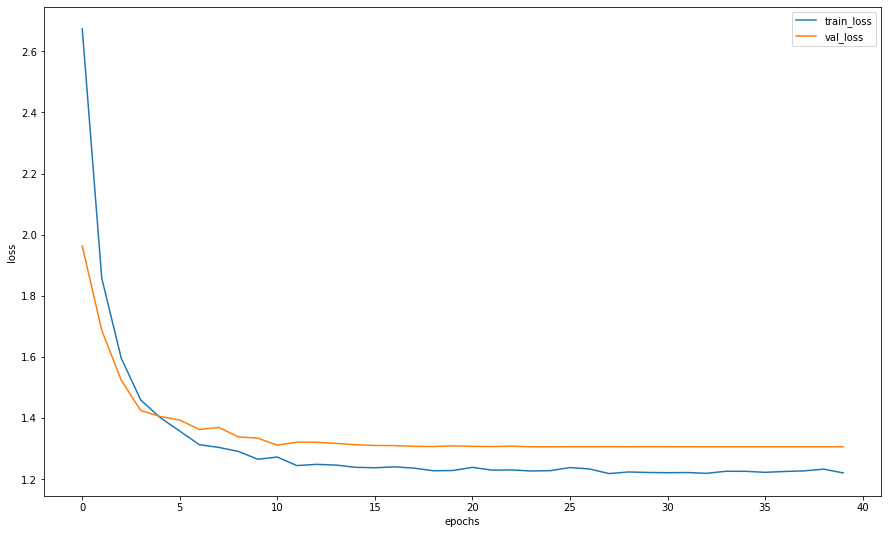

In [23]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title()
plt.show()

In [24]:
import copy

# сохранить веса нашей нейросети model
model_pre_weights = copy.deepcopy(model_resnet.state_dict())
torch.save(model_pre_weights, "C:/Users/Arcry/kaggle/journey-springfield/model_pre_weights.pth")

In [25]:
# Включаем все слои!!!
for child in model_resnet.children():
    for param in child.parameters():
        param.requires_grad = True

In [26]:
history = train(new_train_dataset, val_dataset, model=model_resnet, epochs=20, batch_size=64)

epoch:   0%|                                                                                    | 0/20 [00:00<?, ?it/s]

loss 3.9496756469952157


epoch:   5%|███▋                                                                     | 1/20 [03:51<1:13:18, 231.52s/it]


Epoch 001 train_loss: 3.9497     val_loss 3.2601 train_acc 0.0818 val_acc 0.1074
loss 3.4643776371029795


epoch:  10%|███████▎                                                                 | 2/20 [07:42<1:09:21, 231.21s/it]


Epoch 002 train_loss: 3.4644     val_loss 3.2180 train_acc 0.0881 val_acc 0.1074
loss 3.3859689143939726


epoch:  15%|██████████▉                                                              | 3/20 [11:32<1:05:23, 230.82s/it]


Epoch 003 train_loss: 3.3860     val_loss 3.1118 train_acc 0.0972 val_acc 0.1265
loss 3.146314616796792


epoch:  20%|██████████████▌                                                          | 4/20 [15:23<1:01:30, 230.63s/it]


Epoch 004 train_loss: 3.1463     val_loss 2.6147 train_acc 0.1531 val_acc 0.2736
loss 2.6411607015729137


epoch:  25%|██████████████████▊                                                        | 5/20 [19:13<57:38, 230.55s/it]


Epoch 005 train_loss: 2.6412     val_loss 2.2187 train_acc 0.2807 val_acc 0.4012
loss 1.9775675745571362


epoch:  30%|██████████████████████▌                                                    | 6/20 [23:04<53:47, 230.51s/it]


Epoch 006 train_loss: 1.9776     val_loss 1.6513 train_acc 0.4527 val_acc 0.5369
loss 1.3411717842969428


epoch:  35%|██████████████████████████▎                                                | 7/20 [26:54<49:56, 230.52s/it]


Epoch 007 train_loss: 1.3412     val_loss 1.2114 train_acc 0.6186 val_acc 0.6609
loss 1.0730733229977236


epoch:  40%|██████████████████████████████                                             | 8/20 [30:45<46:06, 230.51s/it]


Epoch 008 train_loss: 1.0731     val_loss 0.8799 train_acc 0.6960 val_acc 0.7596
loss 0.879930958693209


epoch:  45%|█████████████████████████████████▊                                         | 9/20 [34:35<42:16, 230.60s/it]


Epoch 009 train_loss: 0.8799     val_loss 0.7817 train_acc 0.7478 val_acc 0.7940
loss 0.6243654596201839


epoch:  50%|█████████████████████████████████████                                     | 10/20 [38:27<38:28, 230.81s/it]


Epoch 010 train_loss: 0.6244     val_loss 0.6442 train_acc 0.8237 val_acc 0.8349
loss 0.5364979028926776


epoch:  55%|████████████████████████████████████████▋                                 | 11/20 [42:17<34:36, 230.71s/it]


Epoch 011 train_loss: 0.5365     val_loss 0.5757 train_acc 0.8437 val_acc 0.8525
loss 0.47016241110804563


epoch:  60%|████████████████████████████████████████████▍                             | 12/20 [46:07<30:43, 230.48s/it]


Epoch 012 train_loss: 0.4702     val_loss 0.5738 train_acc 0.8647 val_acc 0.8493
loss 0.3582243371924411


epoch:  65%|████████████████████████████████████████████████                          | 13/20 [49:57<26:52, 230.34s/it]


Epoch 013 train_loss: 0.3582     val_loss 0.5118 train_acc 0.8995 val_acc 0.8749
loss 0.32247895369801505


epoch:  70%|███████████████████████████████████████████████████▊                      | 14/20 [53:47<23:01, 230.25s/it]


Epoch 014 train_loss: 0.3225     val_loss 0.4937 train_acc 0.9079 val_acc 0.8808
loss 0.29457164428838334


epoch:  75%|███████████████████████████████████████████████████████▌                  | 15/20 [57:37<19:11, 230.22s/it]


Epoch 015 train_loss: 0.2946     val_loss 0.5011 train_acc 0.9160 val_acc 0.8819
loss 0.2629860836893978


epoch:  80%|█████████████████████████████████████████████████████████▌              | 16/20 [1:01:27<15:20, 230.19s/it]


Epoch 016 train_loss: 0.2630     val_loss 0.4649 train_acc 0.9245 val_acc 0.8917
loss 0.22899126679664564


epoch:  85%|█████████████████████████████████████████████████████████████▏          | 17/20 [1:05:17<11:30, 230.08s/it]


Epoch 017 train_loss: 0.2290     val_loss 0.4696 train_acc 0.9357 val_acc 0.8926
loss 0.2178278076107477


epoch:  90%|████████████████████████████████████████████████████████████████▊       | 18/20 [1:09:08<07:40, 230.25s/it]


Epoch 018 train_loss: 0.2178     val_loss 0.4885 train_acc 0.9362 val_acc 0.8888
loss 0.195713637746622


epoch:  95%|████████████████████████████████████████████████████████████████████▍   | 19/20 [1:12:59<03:50, 230.37s/it]


Epoch 019 train_loss: 0.1957     val_loss 0.4657 train_acc 0.9441 val_acc 0.8995
loss 0.18116275776941437


epoch: 100%|████████████████████████████████████████████████████████████████████████| 20/20 [1:16:49<00:00, 230.49s/it]


Epoch 020 train_loss: 0.1812     val_loss 0.4761 train_acc 0.9484 val_acc 0.8984


In [27]:
# # сохранить веса нашей нейросети model
model_25epoch_weights = copy.deepcopy(model_resnet.state_dict())
torch.save(model_25epoch_weights, "C:/Users/Arcry/kaggle/journey-springfield/model_25epoch_weights.pth")

Построим кривые обучения

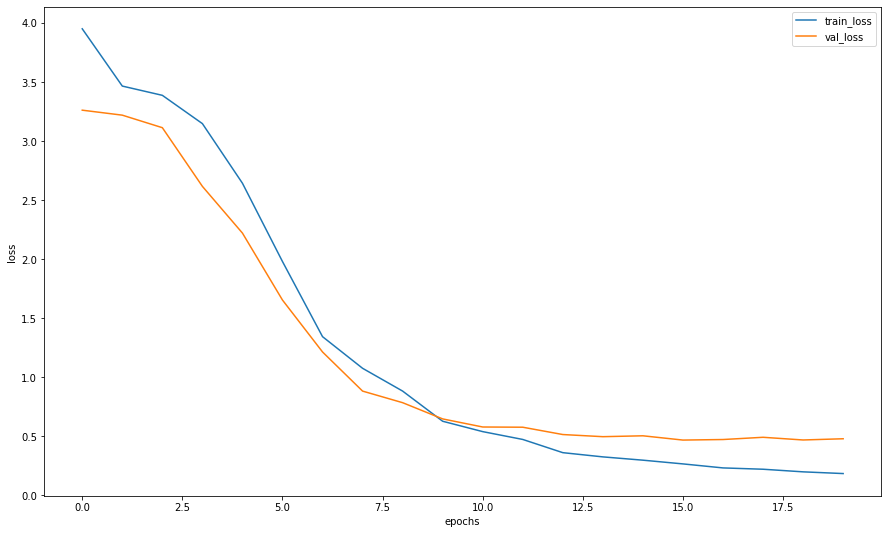

In [62]:
plt_loss(history)

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [30]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [31]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_resnet, ex_img.unsqueeze(0))

In [32]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_resnet, imgs)

In [33]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [34]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [35]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')


1.0

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

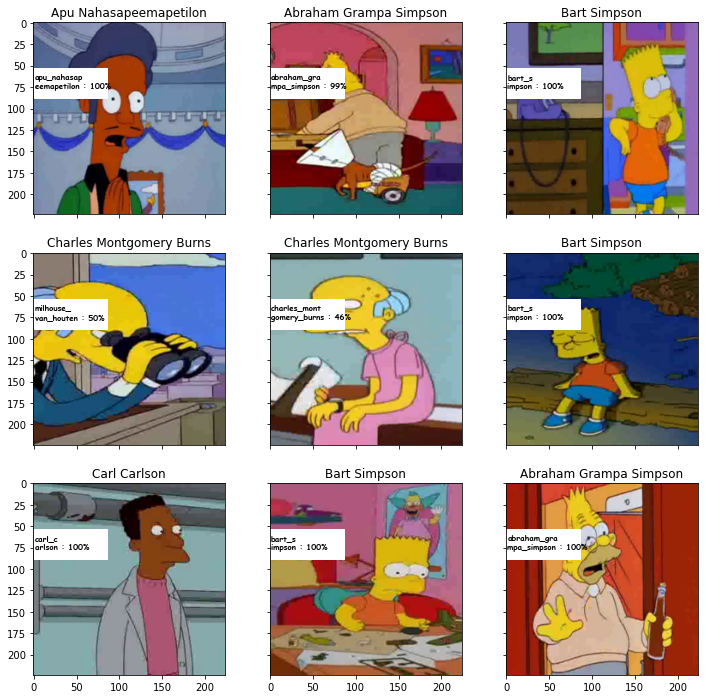

In [36]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_resnet, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

**В итоге модель VGG16 в отключенными первыми 12 слоями смогла достичь точности > 95% на kaggle**

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [37]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
! ls 

In [38]:
import pandas as pd
my_submit = pd.read_csv("C:/Users/Arcry/kaggle/journey-springfield/sample_submission.csv")
my_submit = pd.DataFrame({'id': test_filenames, 'Expected': preds})
my_submit.head()

,id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [39]:
my_submit.to_csv('C:/Users/Arcry/kaggle/journey-springfield/resnet.csv', index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
